In [1]:
import boto3
import botocore
import json
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

glue = boto3.client('glue')
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'escience-workshop-{{FIXME}}'
amazon_review_bucket = 'amazon-reviews-pds'

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': region})
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket {0} could not be created.'.format(bucket)
    return 'Created {0} bucket.'.format(bucket)

In [3]:
try:
    s3_resource.Bucket(amazon_review_bucket).download_file('tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz', 'amazon_reviews_us_Grocery_v1_00.tsv.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [4]:
!gzip -d amazon_reviews_us_Grocery_v1_00.tsv.gz

In [5]:
!ls -la

total 1090104
drwxrwxr-x 3 ec2-user ec2-user     12288 Apr 22 01:42 .
drwxrwxr-x 6 ec2-user ec2-user      4096 Apr 17 18:05 ..
-rw-rw-r-- 1 ec2-user ec2-user      4654 Apr 20 21:37 0000.ipynb
-rw-rw-r-- 1 ec2-user ec2-user      2217 Apr 17 21:05 000AAA.ipynb
-rw-rw-r-- 1 ec2-user ec2-user     44615 Apr 20 21:37 00DATA COLLECTION.ipynb
-rw-rw-r-- 1 ec2-user ec2-user     28678 Apr 20 21:24 0350PROJECT.ipynb
-rw-rw-r-- 1 ec2-user ec2-user      1521 Apr 17 17:59 1000-genomes.yaml
-rw-rw-r-- 1 ec2-user ec2-user    421065 Apr 22 01:41 350FINAL PROJECT.ipynb
-rw-rw-r-- 1 ec2-user ec2-user       817 Apr 17 17:59 3kricegenome.yaml
-rw-rw-r-- 1 ec2-user ec2-user       908 Apr 17 17:59 990-spreadsheets.yaml
-rw-rw-r-- 1 ec2-user ec2-user      1109 Apr 17 17:59 aev-a2d2.yaml
-rw-rw-r-- 1 ec2-user ec2-user      2074 Apr 17 17:59 afsis.yaml
-rw-rw-r-- 1 ec2-user ec2-user      2049 Apr 17 17:59 allen-brain-observatory.yaml
-rw-rw-r-- 1 ec2-user ec2-user      3736 Apr 17 17:59 allen-cell-imaging-colle

In [6]:
df = pd.read_csv('amazon_reviews_us_Grocery_v1_00.tsv', sep='\t', error_bad_lines=False)
df.head()

Skipping line 1925: expected 15 fields, saw 22
Skipping line 1977: expected 15 fields, saw 22
Skipping line 35265: expected 15 fields, saw 22
Skipping line 53357: expected 15 fields, saw 22

Skipping line 68361: expected 15 fields, saw 22
Skipping line 70922: expected 15 fields, saw 22
Skipping line 73503: expected 15 fields, saw 22
Skipping line 85612: expected 15 fields, saw 22
Skipping line 102322: expected 15 fields, saw 22

Skipping line 158341: expected 15 fields, saw 22
Skipping line 162872: expected 15 fields, saw 22
Skipping line 195697: expected 15 fields, saw 22

Skipping line 202916: expected 15 fields, saw 22
Skipping line 203949: expected 15 fields, saw 22
Skipping line 250853: expected 15 fields, saw 22

Skipping line 265820: expected 15 fields, saw 22
Skipping line 304569: expected 15 fields, saw 22
Skipping line 313136: expected 15 fields, saw 22
Skipping line 313160: expected 15 fields, saw 22
Skipping line 316345: expected 15 fields, saw 22
Skipping line 320940: expe

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix, 23-Ounce Bags (Pack of 6)",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Matcha (No Sugar Added - Unsweetened Pure Green Tea - No Coloring Added Like Others) 4oz,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend loves it too.,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-Count (Pack of 12)",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [7]:
len(df)

2393379

In [8]:
df = df.loc[:, ['review_body', 'star_rating']]
df = df.query('star_rating != 3.0')
df.head()

,review_body,star_rating
0,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",5
1,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",5
2,This green tea tastes so good! My girlfriend loves it too.,5
3,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,5
4,good,5


In [9]:
def get_sentiment(value):
    if value > 3:
        return "positive"
    else:
        return "negative"

In [10]:
df['sentiment'] = df['star_rating'].apply(get_sentiment)

In [11]:
df.head()

,review_body,star_rating,sentiment
0,"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years.",5,positive
1,"My favorite nut. Creamy, crunchy, salty, and slightly sweet - what more could you ask for?",5,positive
2,This green tea tastes so good! My girlfriend loves it too.,5,positive
3,I love Melissa's brand but this is a great second when I can't get Melissa's brand.,5,positive
4,good,5,positive


In [12]:
df.star_rating.unique()

array([5, 2, 1, 4, nan, '4', '5', '3', '1', '2', '2013-02-21'],
      dtype=object)

In [13]:
df.dropna(inplace=True)

5    1611588
4    283531 
1    174619 
2    101895 
5    44247  
4    8793   
1    4779   
3    4714   
2    3001   
Name: star_rating, dtype: int64


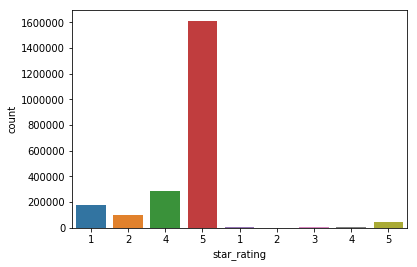

In [15]:
print(df['star_rating'].value_counts())
sns.countplot(x='star_rating', data=df)

In [16]:
import string
df = df.drop_duplicates(subset={'review_body', 'star_rating'})

df.dropna(inplace=True)
df.loc[:, 'star_rating'] = df['star_rating'].astype(int)
df.loc[:, 'review_body'] = df['review_body'].astype(str).str.lower()
df.head()

,review_body,star_rating,sentiment
0,"as a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire cravings place line of products as it allows us to bake treats with minimal effort and ingredients. most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (note these still have soy and corn). we consume these on a regular basis and have been doing so for years.",5,positive
1,"my favorite nut. creamy, crunchy, salty, and slightly sweet - what more could you ask for?",5,positive
2,this green tea tastes so good! my girlfriend loves it too.,5,positive
3,i love melissa's brand but this is a great second when i can't get melissa's brand.,5,positive
4,good,5,positive


positive    1802648
negative    270754 
Name: sentiment, dtype: int64


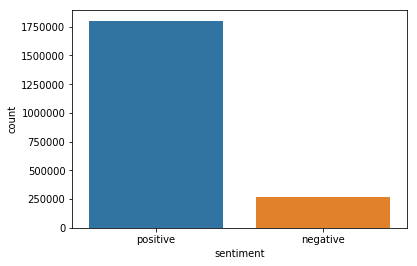

In [17]:
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)

5    1511690
4    278539 
1    175149 
2    103349 
3    4675   
Name: star_rating, dtype: int64


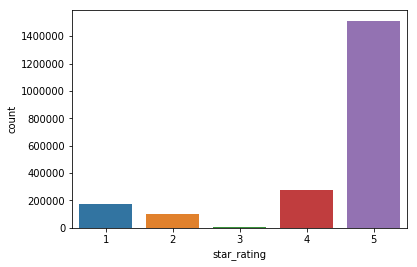

In [18]:
print(df['star_rating'].value_counts())
sns.countplot(x='star_rating', data=df)

tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


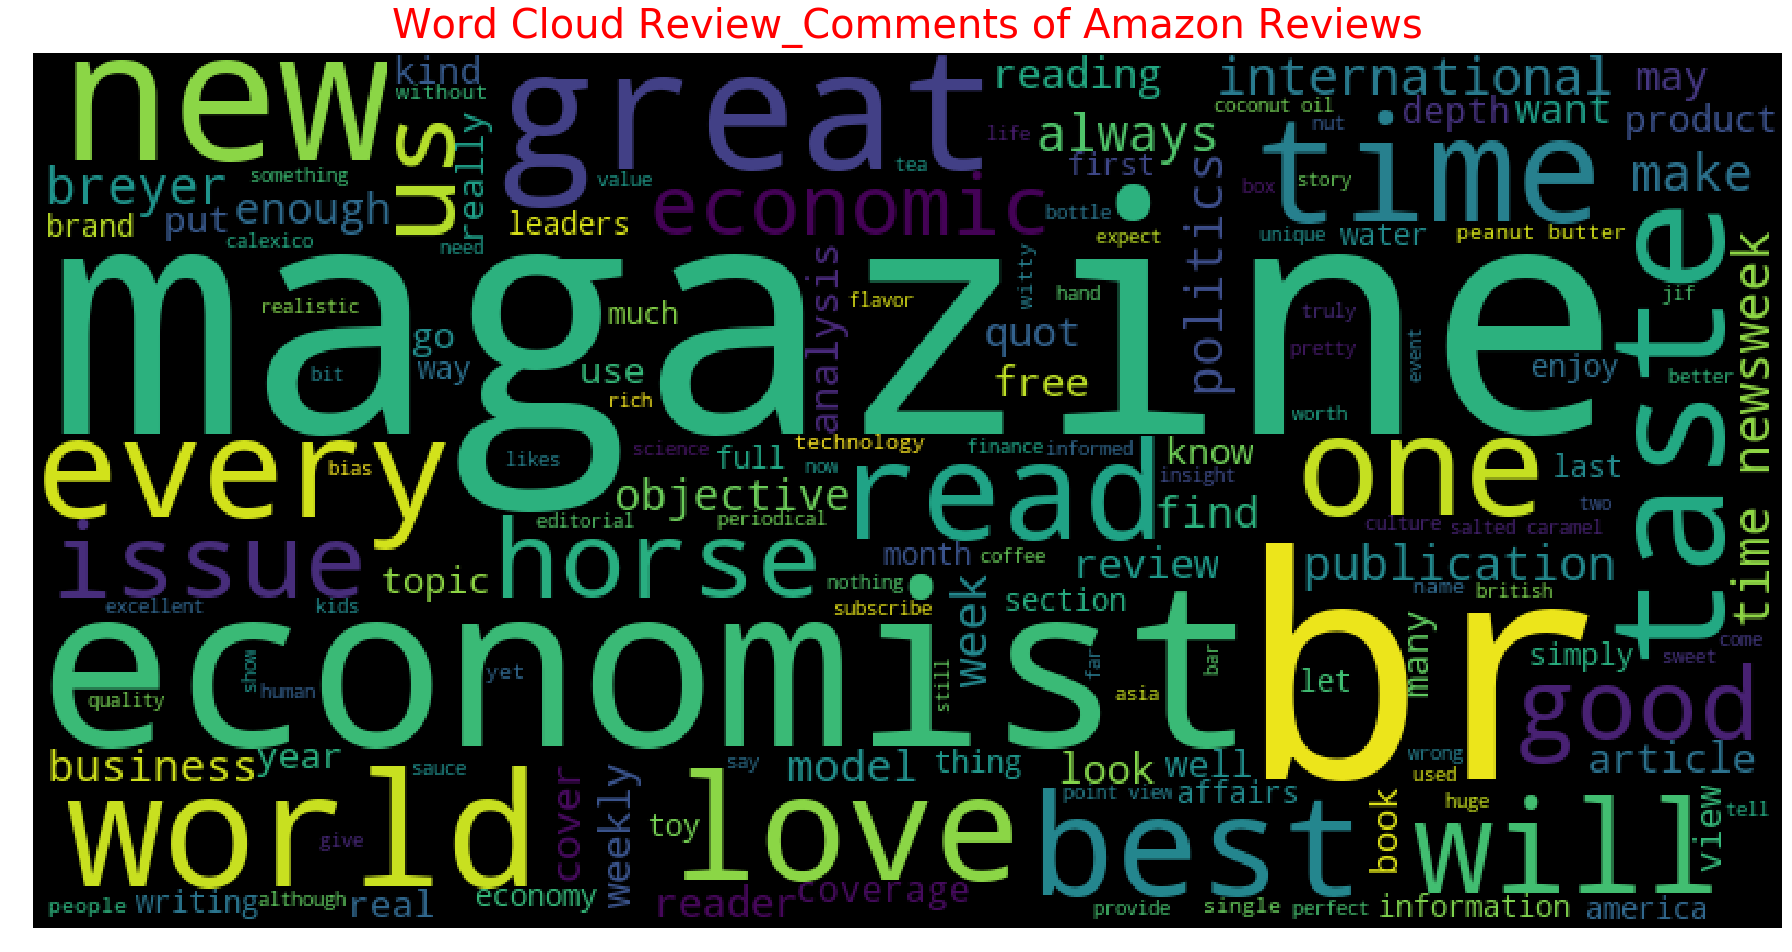

In [19]:
!python -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=150, max_font_size=150, figure_size=(25.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'red', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df['review_body'], title="Word Cloud Review_Comments of Amazon Reviews")

In [ ]:
import string

## Number of words in the text ##
df["num_words"] = df["review_body"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["review_body"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["review_body"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["review_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df["num_punctuations"] = df['review_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
df["mean_word_len"] = df["review_body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [29]:
df.describe()

,star_rating,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
count,2.069455e+06,2.069455e+06,2.069455e+06,2.069455e+06,2.069455e+06,2.069455e+06,2.069455e+06
mean,4.374139e+00,4.532399e+01,3.550300e+01,2.450198e+02,2.183808e+01,9.154413e+00,4.495933e+00
std,1.245277e+00,4.858933e+01,3.088943e+01,2.671462e+02,2.363658e+01,1.322962e+01,7.903106e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.000000e+00,1.900000e+01,1.700000e+01,9.800000e+01,8.000000e+00,3.000000e+00,4.096774e+00
50%,5.000000e+00,3.000000e+01,2.600000e+01,1.600000e+02,1.500000e+01,5.000000e+00,4.391304e+00
75%,5.000000e+00,5.600000e+01,4.500000e+01,2.980000e+02,2.800000e+01,1.000000e+01,4.741379e+00
max,5.000000e+00,5.000000e+02,3.190000e+02,3.547000e+03,2.780000e+02,4.880000e+02,1.990000e+02


In [28]:
print("Correlation of star_rating and num_words: {}".format(df.star_rating.corr(df.num_words)))

Correlation of star_rating and num_words: -0.0856345125811


In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('star_rating ~ num_words', data=df).fit() 
print(results.summary()) # print the summary of the results

                            OLS Regression Results                            
Dep. Variable:            star_rating   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                 1.529e+04
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:46:29   Log-Likelihood:            -3.3828e+06
No. Observations:             2069455   AIC:                         6.766e+06
Df Residuals:                 2069453   BIC:                         6.766e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4736      0.001   3793.015      0.0